<br> </br>
<font size = 8> <center> AI Strategy and Digital transformation </center> </font>
<font size = 6> <center>  <b> 3. Regularization </b> </center>
<br>
<font size = 5> <center> Piotr Wójcik </center> </font>
<font size = 5> <center> University of Warsaw, Poland
<font size = 5> <center> pwojcik@wne.uw.edu.pl
<br> </br>
<font size = 5> <center>  January 2025 </center> </font>
</center> </font>

In [ ]:
# change working directory
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/szkolenia/2025-01_Bucharest'

Mounted at /content/drive
/content/drive/My Drive/szkolenia/2025-01_Bucharest


In [ ]:
# lets import all the needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, balanced_accuracy_score, make_scorer
from sklearn.pipeline import Pipeline

In [ ]:
# lets load the imputed churn data stored before
with open('outputs/houses_prepared.pkl', 'rb') as f:  # 'rb' stands for read in a binary mode
    houses_train = pickle.load(f)
    houses_test = pickle.load(f)

houses_test.head()

,Order,PID,Lot_Frontage,Lot_Area,Lot_Shape,Land_Slope,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,...,Sale_Type_New,Sale_Type_Other,Sale_Type_WD,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Other,Sale_Condition_Partial,Land_Contour_HLS,Land_Contour_Low,Land_Contour_Lvl
0,1,526301100,141,31770,1.0,0.0,4.0,5.0,1960,1960,...,0,0,1,0,1,0,0,0,0,1
1,2,526350040,80,11622,0.0,0.0,5.0,4.0,1961,1961,...,0,0,1,0,1,0,0,0,0,1
2,3,526351010,81,14267,1.0,0.0,4.0,4.0,1958,1958,...,0,0,1,0,1,0,0,0,0,1
3,4,526353030,93,11160,0.0,0.0,3.0,5.0,1968,1968,...,0,0,1,0,1,0,0,0,0,1
4,5,527105010,74,13830,1.0,0.0,5.0,5.0,1997,1998,...,0,0,1,0,1,0,0,0,0,1


## How ridge and LASSO work?

In [ ]:
# lets visualize the effect of parameter shrinkage on 10 selected numerical features

selected_features = ['Sale_Price', 'Lot_Frontage', 'Lot_Area', 'Year_Built',
                    'Total_Bsmt_SF', 'First_Flr_SF', 'Gr_Liv_Area',
                    'TotRms_AbvGrd', 'Garage_Area']

# IMPORTANT !!!
# for the purpose of the ridge or LASSO regression the numerical variables have to be standardized to z-scores !!!

# Create and fit StandardScaler
scaler = StandardScaler()

# Directly create the new scaled DataFrame from fit_transform output
houses_train_scaled = pd.DataFrame(
    scaler.fit_transform(houses_train.loc[:, selected_features]),
    columns = selected_features,
    index = houses_train.index
)

# For the test set, apply transform (not fit_transform)
houses_test_scaled = pd.DataFrame(
    scaler.transform(houses_test.loc[:, selected_features]),
    columns = selected_features,
    index = houses_test.index)


In [ ]:
houses_test_scaled.head()

,Sale_Price,Lot_Frontage,Lot_Area,Year_Built,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,TotRms_AbvGrd,Garage_Area
0,0.410104,2.460311,2.743866,-0.374874,0.061197,1.247164,-0.785375,0.285327,0.339047,0.255369
1,-0.958287,0.655603,0.170777,-0.341764,-0.389738,-0.667951,-0.785375,-1.163313,-0.928951,1.185204
2,-0.124813,0.685189,0.508568,-0.441094,0.628282,0.423161,-0.785375,-0.337970,-0.294952,-0.738910
3,0.770861,1.040213,0.111775,-0.109992,2.406970,2.391193,-0.785375,1.150698,0.973046,0.227750
4,0.097862,0.478091,0.452759,0.850204,-0.284976,-0.587314,0.829347,0.233862,-0.294952,0.043624


In [ ]:
# let's specify 200 values of the shrinkage penalty between 10^(-2) and 1e5 (at equal intervals on a logarithmic scale)
# i.e. from the value close to 0 (almost OLS) to a very high penalty for the values of betas

alphas = np.logspace(-2, 5, 200)

# Split the data into features (X) and target (y)
houses_train_X = houses_train_scaled.drop('Sale_Price', axis = 1)
houses_train_y = houses_train_scaled['Sale_Price']


In [ ]:
# Prepare a list for collecting the coefficients
ridge_coefficients = []
# loop over lambdas (in python alphas)
for alpha in alphas:
    houses_ridge = Ridge(alpha = alpha, fit_intercept = True)
    # fit model
    houses_ridge.fit(houses_train_X, houses_train_y)
    # store latest coefficients
    ridge_coefficients.append(houses_ridge.coef_)

# Convert a list of dicts to a DataFrame
ridge_coefficients_df = pd.DataFrame(ridge_coefficients)

ridge_coefficients_df.head()

# we have betas in subsequent variables in columns and lambdas in rows

,0,1,2,3,4,5,6,7
0,0.026683,0.010798,0.267617,0.164845,0.015558,0.549722,-0.098495,0.173382
1,0.026683,0.010798,0.267617,0.164845,0.015559,0.549721,-0.098494,0.173383
2,0.026683,0.010798,0.267617,0.164845,0.015559,0.549720,-0.098493,0.173383
3,0.026683,0.010798,0.267617,0.164845,0.015559,0.549718,-0.098492,0.173383
4,0.026683,0.010798,0.267617,0.164845,0.015560,0.549717,-0.098491,0.173383


In [ ]:
# for each lambda value we have a set of coefficients.
# the size of matrix of coefficients is therefore
# equal to 200 (number of lambda values) by 9 (number of variables)

ridge_coefficients_df.shape

(200, 8)

<Axes: ylabel='0'>

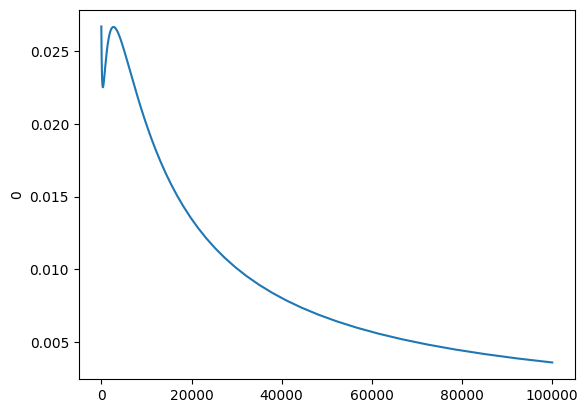

In [ ]:
# estimated coefficients for the FIRST variable (Lot_Frontage) is in the first column
sns.lineplot(x = alphas, y = ridge_coefficients_df.iloc[:, 0])

# lets check how these parameter changes with lambda

We expect that for larger lambdas coefficients will be closer to 0 - and that is what we observe here

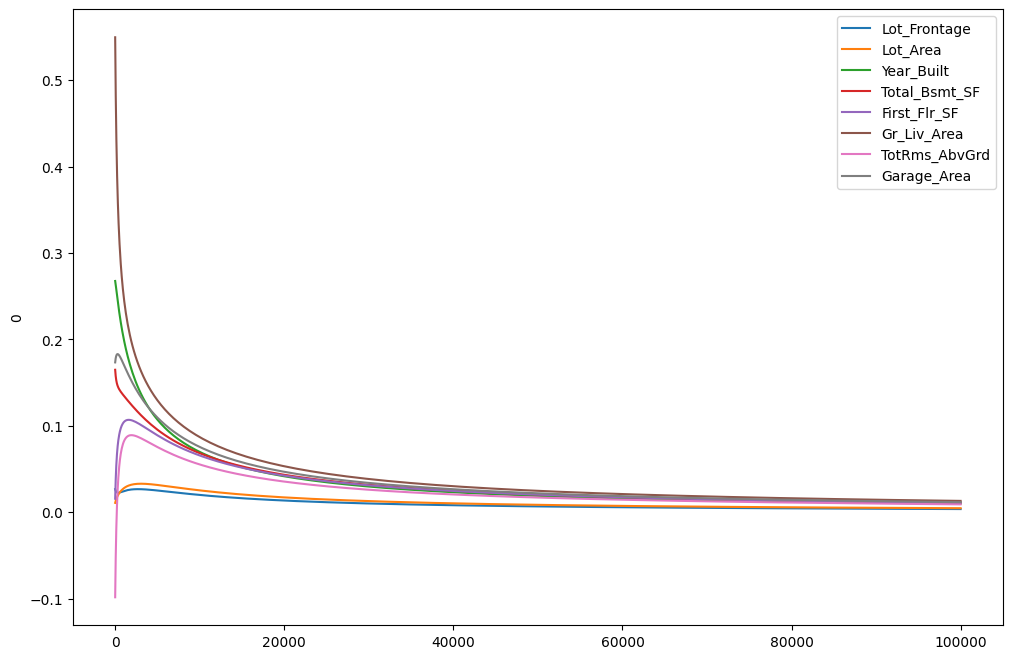

In [ ]:
# Create a color palette with 8 distinct colors
colors = sns.color_palette("tab10", n_colors = 8)

# lets make the figure size larger
plt.figure(figsize=(12, 8))

for i_col in range(8):
    sns.lineplot(
        x = alphas,
        y = ridge_coefficients_df.iloc[:, i_col],
        color = colors[i_col],
        label = houses_train_X.columns[i_col]
    )

Interestingly, as lambda increases initially some parameters may be rising or even switch signs (!) to finally start fall asymptotically to 0

In [ ]:
# lets compare the analogous graph for the LASSO method, but lets use a much smaller range of lambdas/alphas

alphas2 = np.logspace(-4, 1, 200, base = 2)

# Prepare a list for collecting the coefficients
lasso_coefficients = []
# loop over lambdas (in python alphas)
for alpha in alphas2:
    houses_lasso = Lasso(alpha = alpha, fit_intercept = True)
    # fit model
    houses_lasso.fit(houses_train_X, houses_train_y)
    # store latest coefficients
    lasso_coefficients.append(houses_lasso.coef_)

# Convert a list of dicts to a DataFrame
lasso_coefficients_df = pd.DataFrame(lasso_coefficients)

lasso_coefficients_df.head()

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.230833,0.155188,0.014534,0.435118,0.0,0.163870
1,0.0,0.0,0.230160,0.154958,0.014266,0.434578,0.0,0.163600
2,0.0,0.0,0.229475,0.154723,0.013993,0.434029,0.0,0.163326
3,0.0,0.0,0.228778,0.154485,0.013715,0.433470,0.0,0.163047
4,0.0,0.0,0.228069,0.154242,0.013432,0.432901,0.0,0.162762


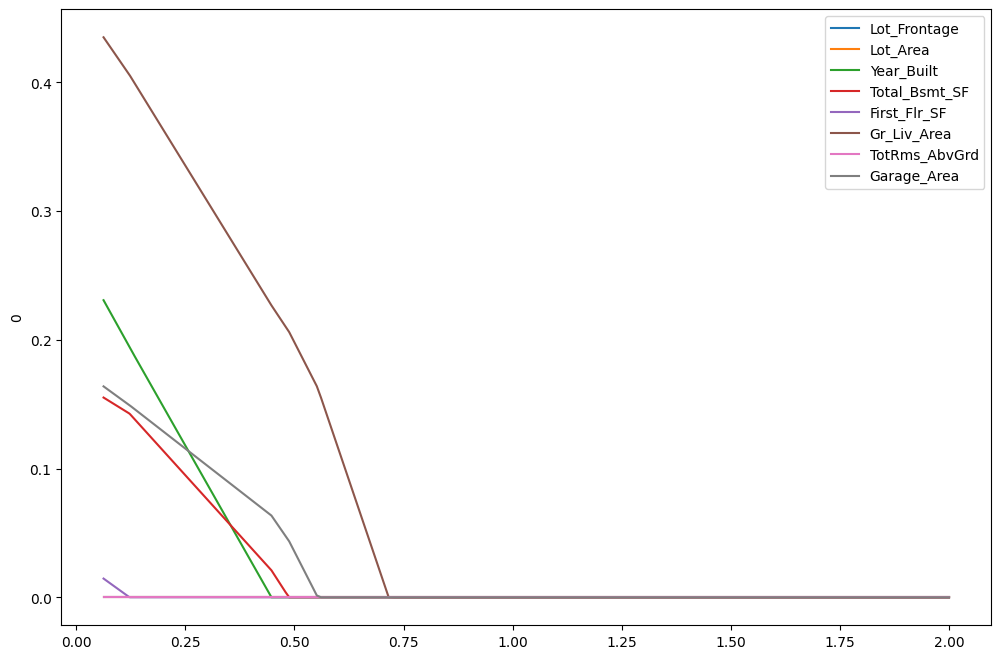

In [ ]:
# lets make the figure size larger
plt.figure(figsize=(12, 8))

for i_col in range(8):
    sns.lineplot(
        x = alphas2,
        y = lasso_coefficients_df.iloc[:, i_col],
        color = colors[i_col],
        label = houses_train_X.columns[i_col]
    )

Here for lambda below 0.75 all parameters become 0, the last variable left is `Gr_Liv_Area`.
That is how LASSO may be used as a initial variable selection method.

## LASSO regression on full houses dataset

In [ ]:
# Lets apply it to the dataset with all variables to check which value of lambda/alpha is optimal and which variables will be selected by LASSO

houses_train_full_X = houses_train.drop(['Order', 'PID','Sale_Price'], axis = 1)
houses_train_full_y = houses_train['Sale_Price']

alphas = np.logspace(-3, 4, 50)

# to correctly approach the normalization within EACH step of cross-validation in sklearn
# we need to define a Pipeline

lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling to z-scores ONLY on the training data in each step
    ('model', Lasso())  # Model
])

# here we use 5-fold cross-validation
cv5 = KFold(n_splits = 5,
            shuffle = True,
            random_state = 123)

# Define grid of hyperparameters
#    Note the syntax "model__alpha": because our pipeline step is named "model"

param_grid = {'model__alpha': alphas}

# Set up of GridSearchCV
lasso_search = GridSearchCV(
    estimator = lasso_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    cv = cv5,
    n_jobs = -1)  # Use all available CPU cores (optional)

# Fit on training data
lasso_search.fit(houses_train_full_X, houses_train_full_y)

# It takes ca 2 minutes

# Print or inspect the best parameters and scores
print("Best alpha:", lasso_search.best_params_)
print("Best (negative) MAE:", lasso_search.best_score_)

# sklearn produces -MAE (and also -MSE) to follow the rule: the higher the better


Best alpha: {'model__alpha': 719.6856730011514}
Best (negative) MAE: -18137.806823814106


<Axes: xlabel='param_model__alpha', ylabel='mean_test_score'>

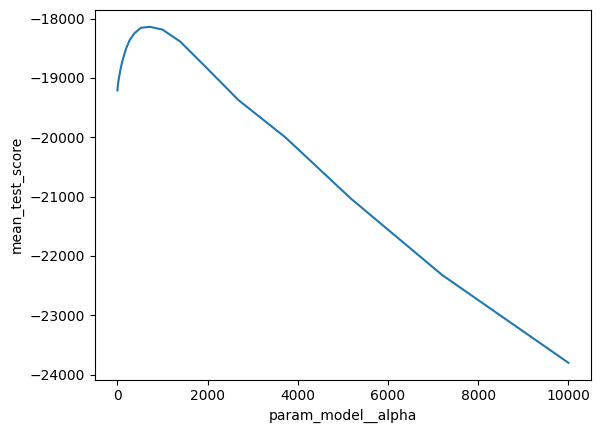

In [ ]:
# If you want the full results for each alpha:
results_df = pd.DataFrame(lasso_search.cv_results_)
# print(results_df[['param_model__alpha', 'mean_test_score', 'rank_test_score']])

sns.lineplot(x = 'param_model__alpha',
             y = 'mean_test_score',
             data = results_df)
# one can see a clear turning point

Best alpha: {'model__alpha': 517.9474679231203}
Best R2: 0.8508859585431019


<Axes: xlabel='param_model__alpha', ylabel='mean_test_score'>

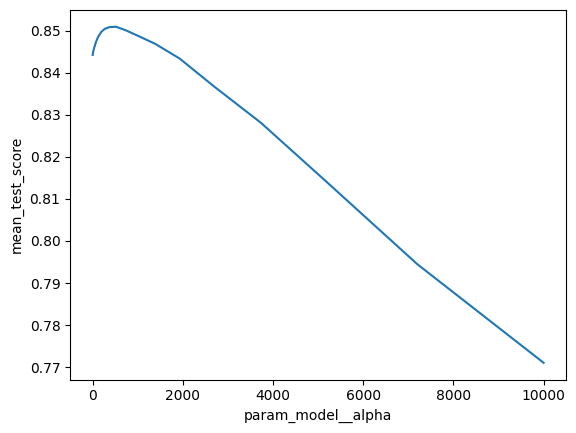

In [ ]:
# lets check how best lambda changes if we optimize R2
# based on the same grid of hyperparameters

# Set up GridSearchCV
lasso_search2 = GridSearchCV(
    estimator = lasso_pipeline,
    param_grid = param_grid,
    scoring = 'r2',
    cv = cv5,
    n_jobs = -1)  # Use all available CPU cores (optional)

# Fit on training data
lasso_search2.fit(houses_train_full_X, houses_train_full_y)

# Print or inspect the best parameters and scores
print("Best alpha:", lasso_search2.best_params_)
print("Best R2:", lasso_search2.best_score_)

# If you want the full results for each alpha:
results2_df = pd.DataFrame(lasso_search2.cv_results_)
# print(results_df[['param_model__alpha', 'mean_test_score', 'rank_test_score']])

sns.lineplot(x = 'param_model__alpha',
             y = 'mean_test_score',
             data = results2_df)

# similar shape

In [ ]:
# lets analyze the best LASSO model

# The best model (including entire pipeline - both the scaler and the LASSO model)
# is already fitted to the entire training set and is available as a .best_estimator_ element

houses_lasso_best = lasso_search.best_estimator_

# we can access its "model" part easily
model_ = houses_lasso_best['model']

# Lets extract all coefficients and align them with the predictors' names
coef_array = model_.coef_
predictor_names = houses_train_full_X.columns

# Build a DataFrame of all predictors + their coefficients
lasso_coef_df = pd.DataFrame({
    'predictor': predictor_names,
    'coefficient': coef_array
})

# Sort by absolute value of the coefficient in descending order
lasso_coef_df['abs_coef'] = lasso_coef_df['coefficient'].abs()
lasso_coef_df.sort_values(by='abs_coef', ascending = False, inplace = True)

# Show 10 most influential features
lasso_coef_df.head(10)

# lasso_coef_df.tail(10)


,predictor,coefficient,abs_coef
21,Gr_Liv_Area,24546.482500,24546.482500
4,Overall_Qual,-15140.231615,15140.231615
76,Neighborhood_Northridge_Heights,10270.430051,10270.430051
75,Neighborhood_Northridge,7608.618922,7608.618922
84,Neighborhood_Stone_Brook,7231.114327,7231.114327
12,Bsmt_Exposure,-6941.860827,6941.860827
28,Kitchen_Qual,-5499.161792,5499.161792
44,MS_SubClass_One_Story_1946_and_Newer_All_Styles,5285.619491,5285.619491
8,Exter_Qual,-4419.902916,4419.902916
5,Overall_Cond,-4097.151826,4097.151826


In [ ]:
# Check how many coefficients were kept and how many removed

(lasso_coef_df.coefficient != 0).value_counts()

# 73 variables were kept (most of them are dummies from recoding categorical predictors)

,count
coefficient,
False,78
True,73


In [ ]:
# lets store the best LASSO model for further comparisons

with open("outputs/model_houses_lasso_best.pkl", "wb") as f:
    pickle.dump(houses_lasso_best, f)

## Ridge regression on full houses dataset

In [ ]:
# similarly lets find the optimal variant of Ridge regression for the whole dataset
alphas = np.logspace(-3, 4, 50)

# to correctly approach the normalization within EACH step of cross-validation in sklearn
# we need to define a Pipeline

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling to z-scores ONLY on the training data in each step
    ('model', Ridge())  # Model
])

# Define grid of hyperparameters - in fact the same as for LASSO before

param_grid = {'model__alpha': alphas}

# Set up of GridSearchCV
ridge_search = GridSearchCV(
    estimator = ridge_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    cv = cv5, # defined before for LASSO
    n_jobs = -1)  # Use all available CPU cores (optional)

# Fit on training data
ridge_search.fit(houses_train_full_X, houses_train_full_y)

# Print or inspect the best parameters and scores
print("Best alpha:", ridge_search.best_params_)
print("Best (negative) MAE:", ridge_search.best_score_)


Best alpha: {'model__alpha': 517.9474679231203}
Best (negative) MAE: -18266.627209164013


<Axes: xlabel='param_model__alpha', ylabel='mean_test_score'>

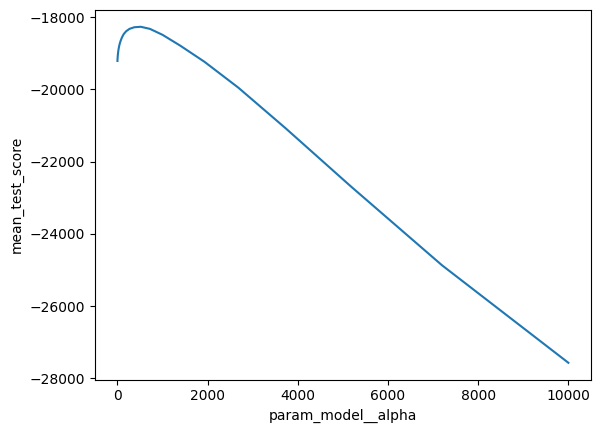

In [ ]:
# Lets check how the MAE depends on lambda/alpha in case of ridge regression:
ridge_search_df = pd.DataFrame(ridge_search.cv_results_)

sns.lineplot(x = 'param_model__alpha',
             y = 'mean_test_score',
             data = ridge_search_df)

In [ ]:
# lets store the best Ridge model for further comparisons
houses_ridge_best = ridge_search.best_estimator_

with open("outputs/model_houses_ridge_best.pkl", "wb") as f:
    pickle.dump(houses_ridge_best, f)

## Elastic net on full houses dataset

In [ ]:
# last but not least, lets estimate the combination of LASSO and ridge - the elastic net

# Keep the range of lambdas/alphas as thinner than before and use less values
alphas = np.logspace(-1, 4, 20)

# define real alpha (in python called l1_ratio) which takes values from [0,1].
#    0.0 = pure Ridge, 1.0 = pure Lasso, in-between is ElasticNet.
l1_ratios = np.linspace(0, 1, 5)  # e.g. 0, 0.2, ..., 1.0

# Build a pipeline: scaling + ElasticNet
elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('model', ElasticNet())        # ElasticNet model
])

# Define parameter grid - now we tune over alpha and l1_ratio
param_grid = {
    'model__alpha': alphas,
    'model__l1_ratio': l1_ratios}

# Set up GridSearchCV
elastic_search = GridSearchCV(
    estimator = elastic_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',  # or another appropriate metric
    cv = cv5, # again the same 5-fold CV as defined before
    n_jobs = -1)

# Fit on training data
elastic_search.fit(houses_train_full_X, houses_train_full_y)

# Print or inspect the best parameters and cross-validation score
print("Best alpha:", elastic_search.best_params_['model__alpha'])
print("Best l1_ratio:", elastic_search.best_params_['model__l1_ratio'])
print("Best (negative) MAE:", elastic_search.best_score_)

# The best estimator (pipeline) including the best alpha and l1_ratio
best_elastic_model = elastic_search.best_estimator_

# optimal elastic-net is a pure LASSO model (l1_ratio = 1)
# we have it already, so we do not store it once again

Best alpha: 885.8667904100823
Best l1_ratio: 1.0
Best (negative) MAE: -18155.84564205174


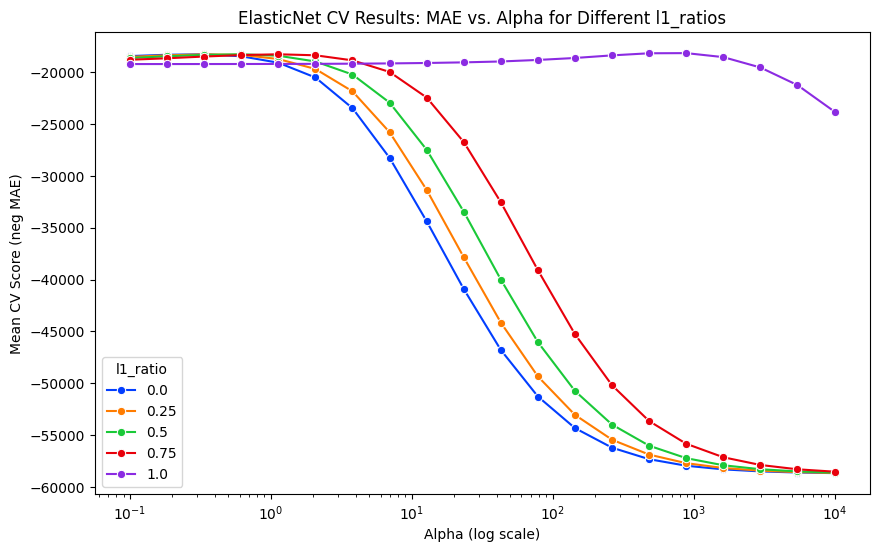

In [ ]:
# lets try to summarize the results of the last cross-validation on the plot

# Convert cross-validation results to a DataFrame
elastic_search_df = pd.DataFrame(elastic_search.cv_results_)

plt.figure(figsize=(10,6))
# Plot mean_test_score vs. alpha, grouping by l1_ratio
sns.lineplot(
    x = 'param_model__alpha',
    y = 'mean_test_score',
    hue = 'param_model__l1_ratio',
    data = elastic_search_df,
    palette = 'bright',
    marker = 'o'
)

plt.xscale('log')  # if alpha is log-spaced, it's often nice to see on a log scale
plt.xlabel("Alpha (log scale)")
plt.ylabel("Mean CV Score (neg MAE)")
plt.title("ElasticNet CV Results: MAE vs. Alpha for Different l1_ratios")
plt.legend(title="l1_ratio")
plt.show()

## Comparison on model's performance on test data

In [ ]:
# Finally test compare all models performance on the test data

houses_test_full_X = houses_test.drop(['Order', 'PID','Sale_Price'], axis = 1)
houses_test_full_y = houses_test['Sale_Price']

# LASSO
houses_predictions_lasso = houses_lasso_best.predict(houses_test_full_X)

# Ridge
houses_predictions_ridge = houses_ridge_best.predict(houses_test_full_X)

In [ ]:
# lets estime a basic linear regression model for comparison

# Initialize the LinearRegression model
linear_model = LinearRegression()

# Fit the model on the training data
linear_model.fit(houses_train_full_X, houses_train_full_y)

# Predict on the test data
houses_predictions_linear = linear_model.predict(houses_test_full_X)

In [ ]:
def evaluate_model(y_true, y_pred):
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Absolute Percentage Error (avoid division by zero)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # R-squared (coefficient of determination)
    r2 = r2_score(y_true, y_pred)

    # Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error
    rmse = np.sqrt(mse)

    return {
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse
    }

# Evaluate LASSO model
lasso_metrics = evaluate_model(houses_test_full_y, houses_predictions_lasso)
# Evaluate Ridge model
ridge_metrics = evaluate_model(houses_test_full_y, houses_predictions_ridge)
# Evaluate Linear Regression model
linear_metrics = evaluate_model(houses_test_full_y, houses_predictions_linear)

metrics_df = pd.DataFrame({
    'OLS': linear_metrics,
    'LASSO': lasso_metrics,
    'Ridge': ridge_metrics
})

metrics_df

# here ridge does the best

,OLS,LASSO,Ridge
MAE,1.829620e+04,1.808530e+04,1.792037e+04
MAPE,1.157532e+01,1.154469e+01,1.140093e+01
R2,8.830879e-01,8.831336e-01,8.837825e-01
MSE,7.259485e+08,7.256647e+08,7.216354e+08
RMSE,2.694343e+04,2.693816e+04,2.686327e+04


In [ ]:
# Regularization can also be applied for the classification problem

# lets see a simple example with a single variant of LASSO

# lets load the imputed churn data stored before
with open('outputs/churn_prepared.pkl', 'rb') as f:  # 'rb' stands for read in a binary mode
    churn_train_encoded = pickle.load(f)
    churn_test_encoded = pickle.load(f)

churn_test_encoded.head()

,customer_id,customer_age,customer_number_of_dependents,customer_education,customer_salary_range,customer_relationship_length,customer_available_credit_limit,total_products,period_inactive,contacts_in_last_year,...,customer_gender_Unknown,customer_civil_status_Divorced,customer_civil_status_Married,customer_civil_status_Single,customer_civil_status_Unknown,credit_card_classification_Blue,credit_card_classification_Gold,credit_card_classification_Platinum,credit_card_classification_Silver,account_status_closed
2089,122823,-1.179263,0.490392,4.0,0.0,-1.875667,-0.460621,-0.047547,-0.341229,-0.402278,...,0,0,0,1,0,1,0,0,0,1
8911,674482,0.824459,-0.276069,2.0,5.0,1.382108,-0.146121,-0.363695,-1.324011,-1.306320,...,0,0,1,0,0,1,0,0,0,0
8411,529000,0.824459,0.490392,4.0,2.0,0.880912,-0.094396,0.268601,0.641554,0.501764,...,0,0,0,1,0,1,0,0,0,0
7311,344732,-0.427867,0.490392,4.0,5.0,-0.372079,-0.429807,-0.363695,0.641554,-1.306320,...,0,0,0,1,0,1,0,0,0,0
9211,957784,0.699226,-1.042530,2.0,2.0,1.131510,0.098896,-0.995992,2.607119,-1.306320,...,0,0,0,1,0,1,0,0,0,0


In [ ]:
# train/test split

churn_train_X = churn_train_encoded.drop(['account_status_closed', 'customer_id'], axis = 1)
churn_train_y = churn_train_encoded['account_status_closed']

In [ ]:
# lets start with a simple logistic regression

# apply cross validation to check its predictive performance

# Set up K-Fold cross-validation
cv5 = KFold(n_splits = 5,
            shuffle = True,
            random_state = 123)  # 5 folds

# Initialize logistic regression model
churn_logreg = LogisticRegression(max_iter = 1000, random_state = 123)

# Evaluate the model using K-Fold cross-validation
churn_logreg_cv_scores = cross_val_score(churn_logreg,
                                         churn_train_X,
                                         churn_train_y,
                                         cv = cv5,
                                         scoring = 'balanced_accuracy')

# Print cross-validation accuracy scores
print("Cross-Validation Balanced Accuracy Scores:", churn_logreg_cv_scores)
print("Mean CV Balanced Accuracy:", np.mean(churn_logreg_cv_scores))



Cross-Validation Balanced Accuracy Scores: [0.75388815 0.7179997  0.72667129 0.73951695 0.72675355]
Mean CV Balanced Accuracy: 0.7329659282684914


In [ ]:
# using regularization is simple here as the function LogisticRegression
# directly allows for it with the penalty = argument

# the only difference is that we have to provide 1/lambda here as a C= parameter

# Initialize LASSO logistic regression model with lambda = 0.1
lasso_logreg = LogisticRegression(
    penalty = 'l1',       # Use L1 penalty for LASSO, l2 for ridge
    C = 1/0.1,           # Convert lambda to C (C = 1 / lambda)
    solver = 'saga',      # Use 'saga' solver for L1 regularization
    max_iter = 10000,
    random_state = 123
)

# Evaluate the model using K-Fold cross-validation with balanced accuracy
lasso_logreg_cv_scores = cross_val_score(
    lasso_logreg,
    churn_train_X,
    churn_train_y,
    cv=cv5,
    scoring='balanced_accuracy'
)

# Print cross-validation balanced accuracy scores
print("Cross-Validation Balanced Accuracy Scores:", lasso_logreg_cv_scores)
print("Mean CV Balanced Accuracy:", np.mean(lasso_logreg_cv_scores))

Cross-Validation Balanced Accuracy Scores: [0.75346153 0.7179997  0.72667129 0.73868707 0.7284303 ]
Mean CV Balanced Accuracy: 0.7330499793578324


In [ ]:
# lets check ridge with the same lambda

# Initialize ridge logistic regression model with lambda = 0.1
ridge_logreg = LogisticRegression(
    penalty = 'l2',       # Use L1 penalty for LASSO, l2 for ridge
    C = 1/0.1,           # Convert lambda to C (C = 1 / lambda)
    solver = 'saga',      # Use 'saga' solver for L1 regularization
    max_iter = 10000,
    random_state = 123
)

# Evaluate the model using K-Fold cross-validation with balanced accuracy
ridge_logreg_cv_scores = cross_val_score(
    ridge_logreg,
    churn_train_X,
    churn_train_y,
    cv=cv5,
    scoring='balanced_accuracy'
)

# Print cross-validation balanced accuracy scores
print("Cross-Validation Balanced Accuracy Scores:", ridge_logreg_cv_scores)
print("Mean CV Balanced Accuracy:", np.mean(ridge_logreg_cv_scores))

Cross-Validation Balanced Accuracy Scores: [0.75549405 0.7179997  0.72667129 0.73632858 0.7284303 ]
Mean CV Balanced Accuracy: 0.7329847853096656


In [ ]:
# elastic-net also works

# Initialize elasticnet logistic regression model with lambda = 0.1
elastic_logreg = LogisticRegression(
    penalty = 'elasticnet',
    l1_ratio = 0.5, # needed for elastic net
    C = 1/0.1,           # Convert lambda to C (C = 1 / lambda)
    solver = 'saga',      # Use 'saga' solver for L1 regularization
    max_iter = 10000,
    random_state = 123
)

# Evaluate the model using K-Fold cross-validation with balanced accuracy
elastic_logreg_cv_scores = cross_val_score(
    ridge_logreg,
    churn_train_X,
    churn_train_y,
    cv=cv5,
    scoring = 'balanced_accuracy'
)

# Print cross-validation balanced accuracy scores
print("Cross-Validation Balanced Accuracy Scores:", elastic_logreg_cv_scores)
print("Mean CV Balanced Accuracy:", np.mean(elastic_logreg_cv_scores))

Cross-Validation Balanced Accuracy Scores: [0.75549405 0.7179997  0.72667129 0.73632858 0.7284303 ]
Mean CV Balanced Accuracy: 0.7329847853096656


# Exercises 3

## Exercise 3.1

With the use of cross-validation find the optimal variant of the LASSO regularized logistic regression based on the churn dataset.



In [ ]:
# place for the solution fo 3.1

## Exercise 3.2

With the use of cross-validation find the optimal variant of the Ridge regularized logistic regression based on the churn dataset.

In [ ]:
# place for the solution fo 3.2

## Exercise 3.3

With the use of cross-validation find the optimal variant of the elastic-net regularized logistic regression based on the churn dataset

In [ ]:
# place for the solution fo 3.3

## Exercise 3.4

Compare the performance of the best models from exercises 3.1-3.3 on the test sample. Use non-regularized logistic regression as a benchmark. Does regularization help?

In [ ]:
# place for the solution fo 3.4

In [ ]:
# Additional sources:
# https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/
# https://machinelearningmastery.com/ridge-regression-with-python/

